## Comparison of Markov VS. ECDF Approach

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
# Read data
df = pd.read_csv('stocks_aggregated.csv')
print(df["Sector"].value_counts())
# Unique categories
categories = df["Sector"].unique()

# normalize to percentage
df['norm_pctChange'] = df['pctChange']*100

# reset variable
categories = df["Sector"].unique()
df.tail()

Sector
Basic Materials           3768
Communication Services    3768
Consumer Cyclical         3768
Consumer Defensive        3768
Energy                    3768
Financial Services        3768
Healthcare                3768
Industrials               3768
Real Estate               3768
Technology                3768
Utilities                 3768
Name: count, dtype: int64


,Date,Sector,Adj Close,pctChange,up_ind,norm_pctChange
41443,2024-12-20,Healthcare,4061.319965,0.015142,1,1.514219
41444,2024-12-20,Industrials,5892.510040,0.014285,1,1.428518
41445,2024-12-20,Real Estate,2011.869986,0.012776,1,1.277629
41446,2024-12-20,Technology,2744.200005,0.013798,1,1.379832
41447,2024-12-20,Utilities,682.539993,0.015080,1,1.508030


ECDF Simulation Code:

In [112]:
# map to store sector dfs
df_map = {}

# map to store pct_change values for each sector
pct_map = {}

# Creates dictionary with pctChange values of each sector
for cat in categories:

    # filters by sector and maps sector name to sector df
    subset = df[df["Sector"] == cat].reset_index(drop=True)
    df_map[cat] = subset

    # converts each sector's pct change to array and maps values to name of sector
    subset = df[df["Sector"] == cat]['pctChange'].reset_index(drop=True)
    pct_map[cat] = subset.to_numpy()


# set seed for reproducibility
np.random.seed(42)

# loops through and generates new values for each day of each sector and adds to dataframe
for cat in categories:

    new_values = []
    current_vals = pct_map[cat]
    sector_df = df_map[cat]

    # generates new pct_change value for each day
    for i in range(len(pct_map[cat])):

        # Set first day to same value as original data
        if i == 0:
            new_values.append(current_vals[i])
        
        # selects a random PCT_change value from distribution
        else:
            val = np.random.randint(1, len(current_vals))
            new_values.append(current_vals[val])

    # adds new values to dataframe 
    sector_df['Sim_pct_change'] = new_values
    sector_df['Sim_pct_change'] = sector_df['Sim_pct_change'].astype('float64')
    df_map[cat] = sector_df

# Set 5 random seeds for reproducibility
random_seeds = [10, 15, 20, 25, 30]

# Create dictionary to store results for each sector
sim_results = {cat: [] for cat in categories}

# Run 5 simulations
for seed in random_seeds:
    np.random.seed(seed)

    for cat in categories:
        sector_df = df_map[cat].copy()
        current_vals = pct_map[cat]

        # --- Simulate pct_change values ---
        new_pct = []
        for i in range(len(current_vals)):
            if i == 0:
                new_pct.append(current_vals[i])
            else:
                val = np.random.randint(1, len(current_vals))
                new_pct.append(current_vals[val])

        sector_df['Sim_pct_change'] = new_pct

        # --- Calculate new adjusted close values ---
        new_adj = []
        for i in range(len(sector_df)):
            if i == 0:
                new_adj.append(sector_df['Adj Close'].iloc[i])
            else:
                prev_val = new_adj[i-1]
                pct = sector_df['Sim_pct_change'].iloc[i]
                new_adj.append(prev_val * (1 + pct))

        # Store this simulation's adjusted close values
        sim_results[cat].append(new_adj)

# --- Compute average simulated adjusted close across all 5 runs ---
for cat in categories:
    stacked = np.column_stack(sim_results[cat])   # shape: (days, 5)
    avg_adj_close = stacked.mean(axis=1)          # mean per day across sims
    df_map[cat]['Avg_Sim_Adj_Close'] = avg_adj_close

Markov Chain Simulation Code:

In [113]:
def get_transition_matrix(val_col):
    transition_matrix = np.zeros((2, 2))

    for i in range(1, len(val_col)):
        today = val_col[i - 1]
        tomorrow = val_col[i]

        if today == 0:
            if tomorrow == 0:
                transition_matrix[0, 0] += 1
            else:
                transition_matrix[0, 1] += 1
        else:
            if tomorrow == 0:
                transition_matrix[1, 0] += 1
            else:
                transition_matrix[1, 1] += 1

    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(
        transition_matrix,
        row_sums,
        out=np.zeros_like(transition_matrix),
        where=row_sums != 0
    )

    return transition_matrix

In [114]:
matrices = {}
for sector, group in df.groupby('Sector'):
    matrices[sector] = get_transition_matrix(group['up_ind'].to_numpy())

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sectors = ["Basic Materials", "Healthcare", "Real Estate"]
sector_mean_paths = {}

# Plot individual simulations + mean path per sector
for sector in sectors:
    # all_paths for this sector
    g = df[df["Sector"] == sector].sort_values("Date").copy()
    # Re-run simulations to get all paths array
    current = g["up_ind"].iloc[:-1].to_numpy()
    next_state = g["up_ind"].iloc[1:].to_numpy()
    T_counts = np.zeros((2, 2), dtype=float)
    for c, n in zip(current, next_state):
        T_counts[c, n] += 1
    row_sums = T_counts.sum(axis=1, keepdims=True)
    P = np.divide(T_counts, row_sums, where=row_sums != 0)
    p_up_given_up = P[1, 1]
    p_up_given_down = P[0, 1]

    sigma = g["pctChange"].std()
    u = np.exp(sigma)
    d = np.exp(-sigma)


    s0 = g["Adj Close"].iloc[1]
    last_state = int(g["up_ind"].iloc[1])

    n_sim = 5
    T_sim = len(g)
    rng = np.random.default_rng()
    all_paths = np.zeros((n_sim, T_sim + 1))

    for sim in range(n_sim):
        s = s0
        state = last_state
        path = [s]
        shocks = rng.uniform(size=T_sim)
        for t in range(T_sim):
            p_up = p_up_given_up if state == 1 else p_up_given_down
            if shocks[t] < p_up:
                s = s * u
                state = 1
            else:
                s = s * d
                state = 0
            path.append(s)
        all_paths[sim, :] = path

    sector_mean_paths[sector] = all_paths.mean(axis=0)


In [116]:
sector_mean_paths["Real Estate"]

array([  293.13737059,   292.39885578,   291.67015306, ...,
        9916.01042028, 10045.96289957,  9950.4070193 ], shape=(3769,))

In [117]:
df_map['Healthcare']['Avg_Sim_Adj_Close']

0        509.211982
1        512.824841
2        518.709865
3        520.507559
4        519.110684
           ...     
3763    7551.223759
3764    7658.051790
3765    7703.579156
3766    7759.531553
3767    7764.953253
Name: Avg_Sim_Adj_Close, Length: 3768, dtype: float64

Total days simulation tests(Long Term):

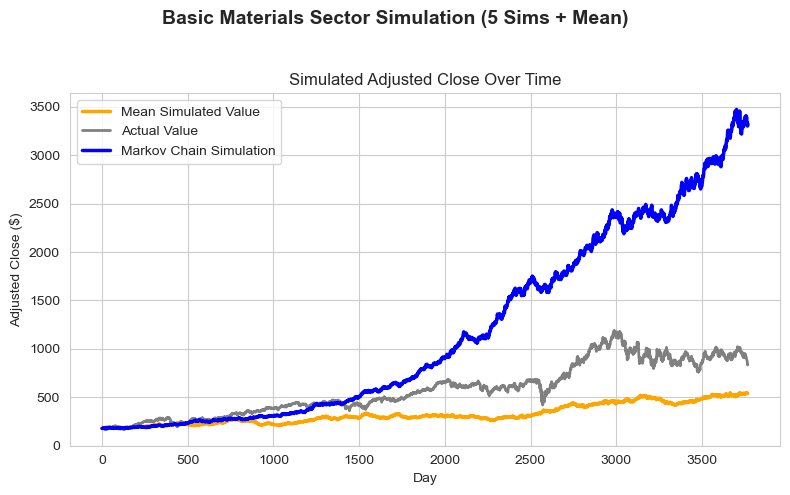

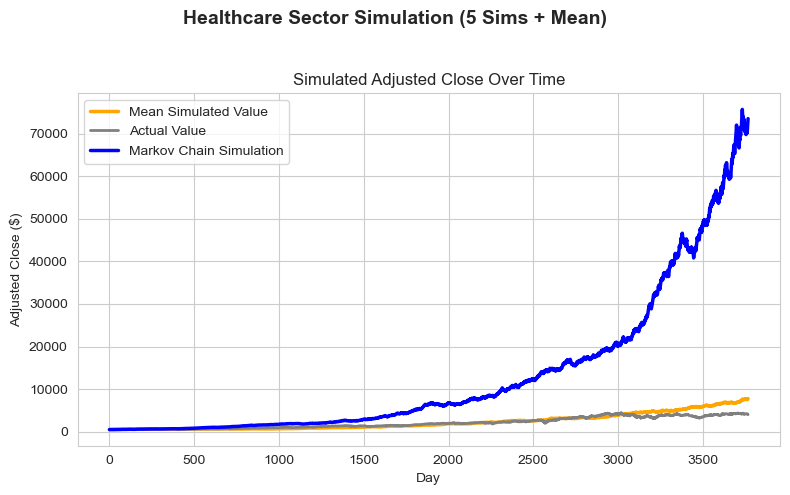

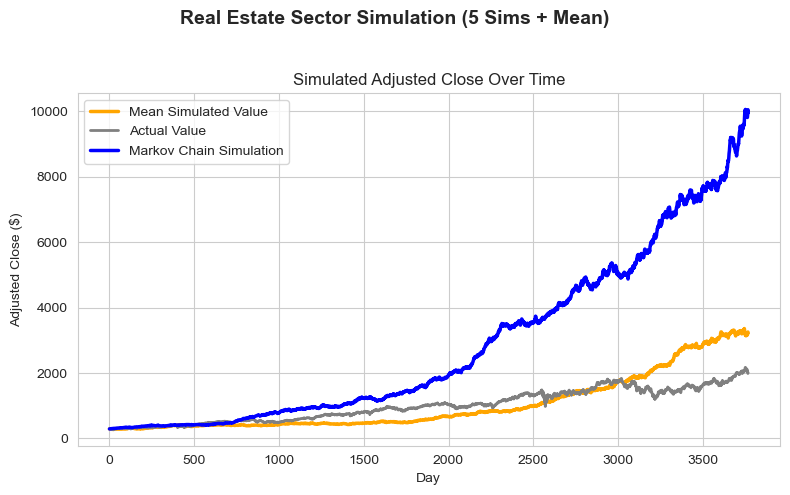

In [118]:
sns.set_style("whitegrid")

# Specify the sector to plot
sectors = ["Basic Materials", "Healthcare", "Real Estate"]

for s in sectors:
# Retrieve DataFrame and simulation results for this sector
    sector_df = df_map[s]
    sim_series = sim_results[s]  # list of 5 simulation series
    avg_adj_close = sector_df["Avg_Sim_Adj_Close"]
    markov_adj_close = sector_mean_paths[s][1:]

# Create a single plot (one axis)
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.suptitle(f"{s} Sector Simulation (5 Sims + Mean)", fontsize=14, fontweight='bold')


# Plot mean of simulations
    ax.plot(sector_df.index, avg_adj_close, color='orange', linewidth=2.5, label="Mean Simulated Value")

# Plot actual (real) value
    ax.plot(sector_df.index, sector_df["Adj Close"], color='gray', linewidth=2, label="Actual Value")

    ax.plot(sector_df.index, markov_adj_close, color='blue', linewidth=2.5, label="Markov Chain Simulation")

# Customize labels and title
    ax.set_title("Simulated Adjusted Close Over Time")
    ax.set_xlabel("Day")
    ax.set_ylabel("Adjusted Close ($)")
    ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


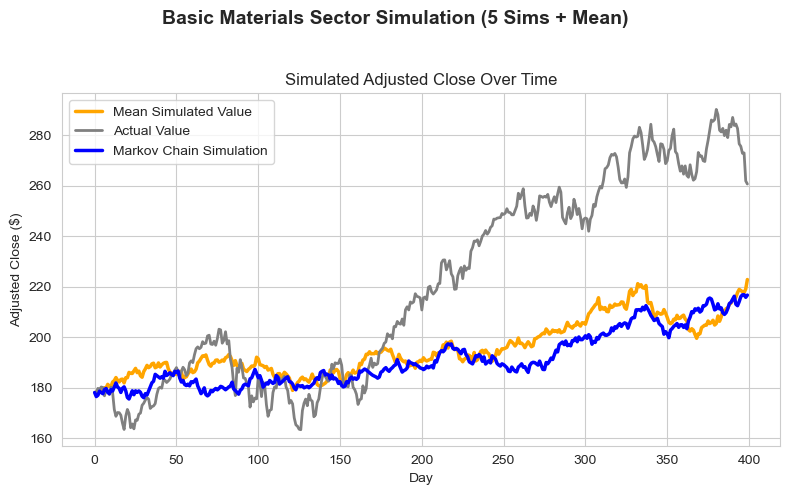

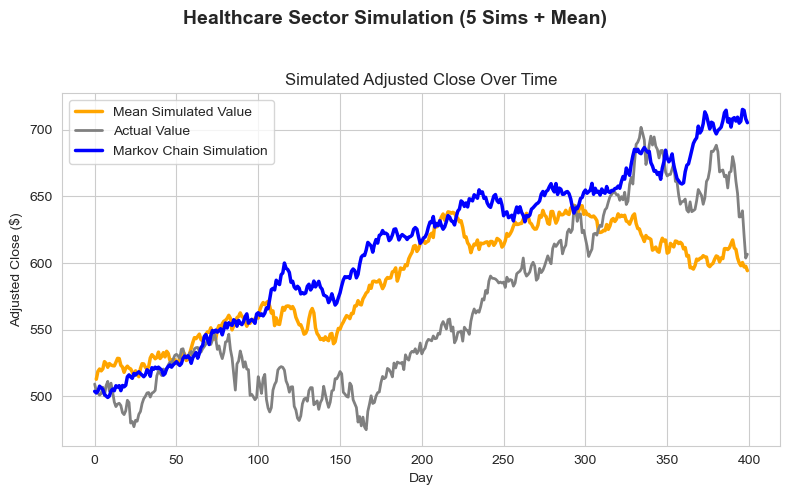

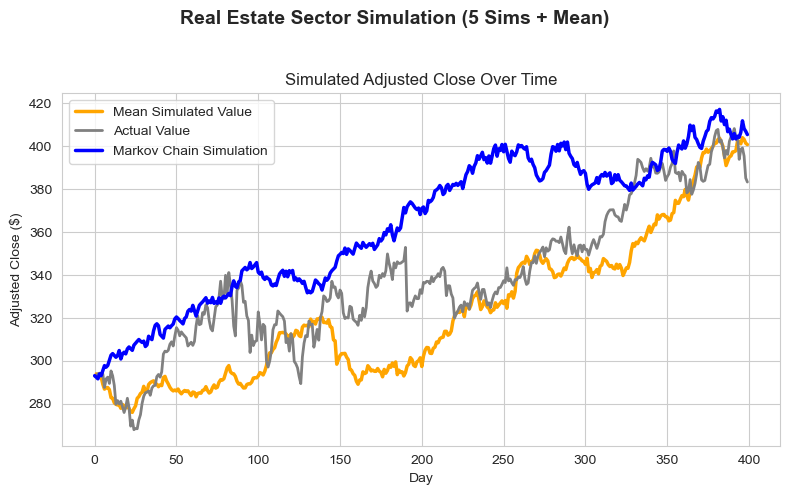

In [119]:
sns.set_style("whitegrid")

# Specify the sector to plot
sectors = ["Basic Materials", "Healthcare", "Real Estate"]

for s in sectors:
# Retrieve DataFrame and simulation results for this sector
    sector_df = df_map[s]
    avg_adj_close_small = sector_df["Avg_Sim_Adj_Close"][1:400]
    markov_adj_close_small = sector_mean_paths[s][:400]

# Create a single plot (one axis)
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.suptitle(f"{s} Sector Simulation (5 Sims + Mean)", fontsize=14, fontweight='bold')


# Plot mean of simulations
    ax.plot(sector_df.index[1:400], avg_adj_close_small, color='orange', linewidth=2.5, label="Mean Simulated Value")

# Plot actual (real) value
    ax.plot(sector_df.index[:400], sector_df["Adj Close"][:400], color='gray', linewidth=2, label="Actual Value")

    ax.plot(sector_df.index[:400], markov_adj_close_small, color='blue', linewidth=2.5, label="Markov Chain Simulation")

# Customize labels and title
    ax.set_title("Simulated Adjusted Close Over Time")
    ax.set_xlabel("Day")
    ax.set_ylabel("Adjusted Close ($)")
    ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
